# 나의 첫 번째 캐글 경진대회, 무작정 따라해보기

## 2019 2nd ML month with KaKR : House Price Prediction

## 프로젝트 루브릭
- 데이터 전처리, 모델학습, 예측의 전체 과정을 거쳐 캐글 submission까지 전과정이 성공적으로 진행되었는가?
- 제출된 노트북이 캐글 커널로 사용될 수 있을 만큼 전처리, 학습, 최적화 진행 과정이 체계적으로 기술되었는가?
- 다양한 피처 엔지니어링과 하이퍼 파라미터 튜닝 등의 최적화 기법을 통해 캐글 리더보드의 Private score 기준 110000 이하의 점수를 얻었는가?

## 용어정리
- max_depth : 의사 결정 나무의 깊이, 정수 사용
- learning_rate : 한 스텝에 이동하는 양을 결정하는 파라미터, 보통 0.0001~0.1 사이의 실수 사용
- n_estimators : 사용하는 개별 모델의 개수, 보통 50~100 이상의 정수 사용
- num_leaves : 하나의 LightGBM 트리가 가질 수 있는 최대 잎의 수
- boosting_type : 부스팅 방식, gbdt, rf 등의 문자열 입력

## 필요한 라이브러리 import 하기

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb
from xgboost import XGBRegressor
import seaborn as sns

## 파일 불러오기

In [2]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data/'

train_data_path = join(data_dir, 'train.csv')
sub_data_path = join(data_dir, 'test.csv')      # 테스트, 즉 submission 시 사용할 데이터 경로

data = pd.read_csv(train_data_path)
sub = pd.read_csv(sub_data_path)
print('train data dim : {}'.format(data.shape))
print('sub data dim : {}'.format(sub.shape))


train data dim : (15035, 21)
sub data dim : (6468, 20)


##  데이터 살펴보기
pandas의 read_csv 함수를 사용해 데이터를 읽어옴
1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 타겟 변수인 집의 가격
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층 수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 2015년 기준 주거 공간의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)
21. sqft_lot15 : 2015년 기준 부지의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)

In [3]:
y = data['price']

del data['price']

print(data.columns)
print('train data dim : {}'.format(data.shape))
print('sub data dim : {}'.format(sub.shape))


Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')
train data dim : (15035, 20)
sub data dim : (6468, 20)


In [4]:
print(y)

0         221900.0
1         180000.0
2         510000.0
3         257500.0
4         291850.0
           ...    
15030     610685.0
15031    1007500.0
15032     360000.0
15033     400000.0
15034     325000.0
Name: price, Length: 15035, dtype: float64


In [5]:
train_len = len(data)
data = pd.concat((data, sub), axis=0)

In [6]:
data.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


## 데이터 전처리

### 결측치 확인
먼저 데이터에 결측치가 있는지를 확인

<AxesSubplot:>

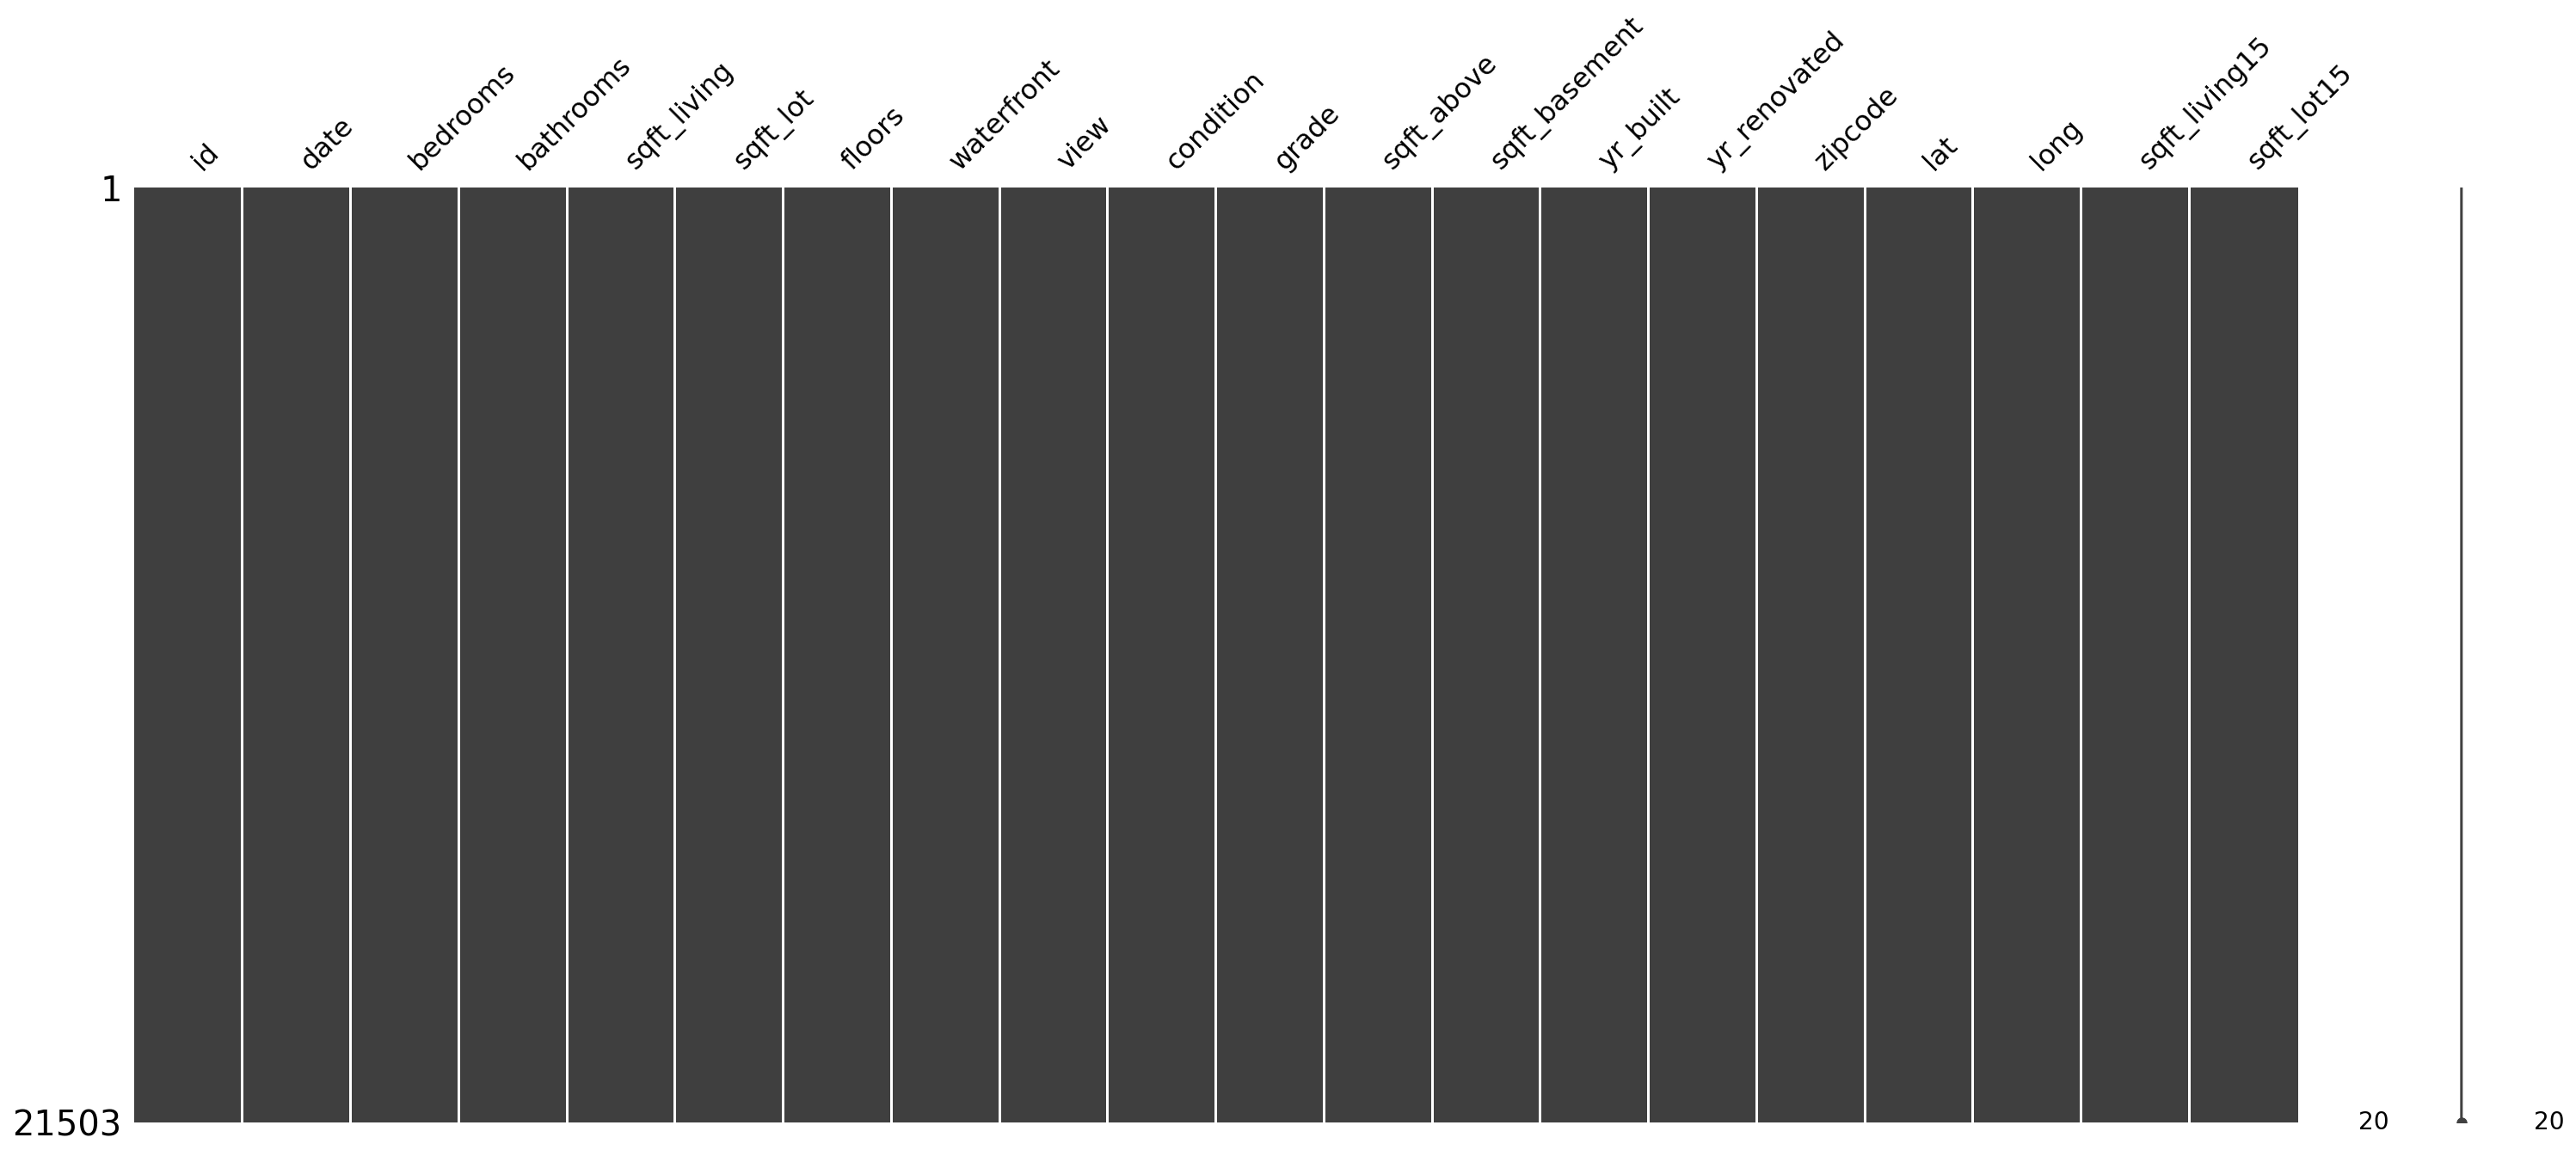

In [7]:
msno.matrix(data)

In [8]:
for c in data.columns:
    print('{} : {}'.format(c, len(data.loc[pd.isnull(data[c]), c].values)))

id : 0
date : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


### id, date 변수 정리

In [9]:
sub_id = data['id'][train_len:]
del data['id']

In [10]:
data['date'] = data['date'].apply(lambda x : str(x[:6])).astype(int)
data.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


### 각 변수들의 분포 확인

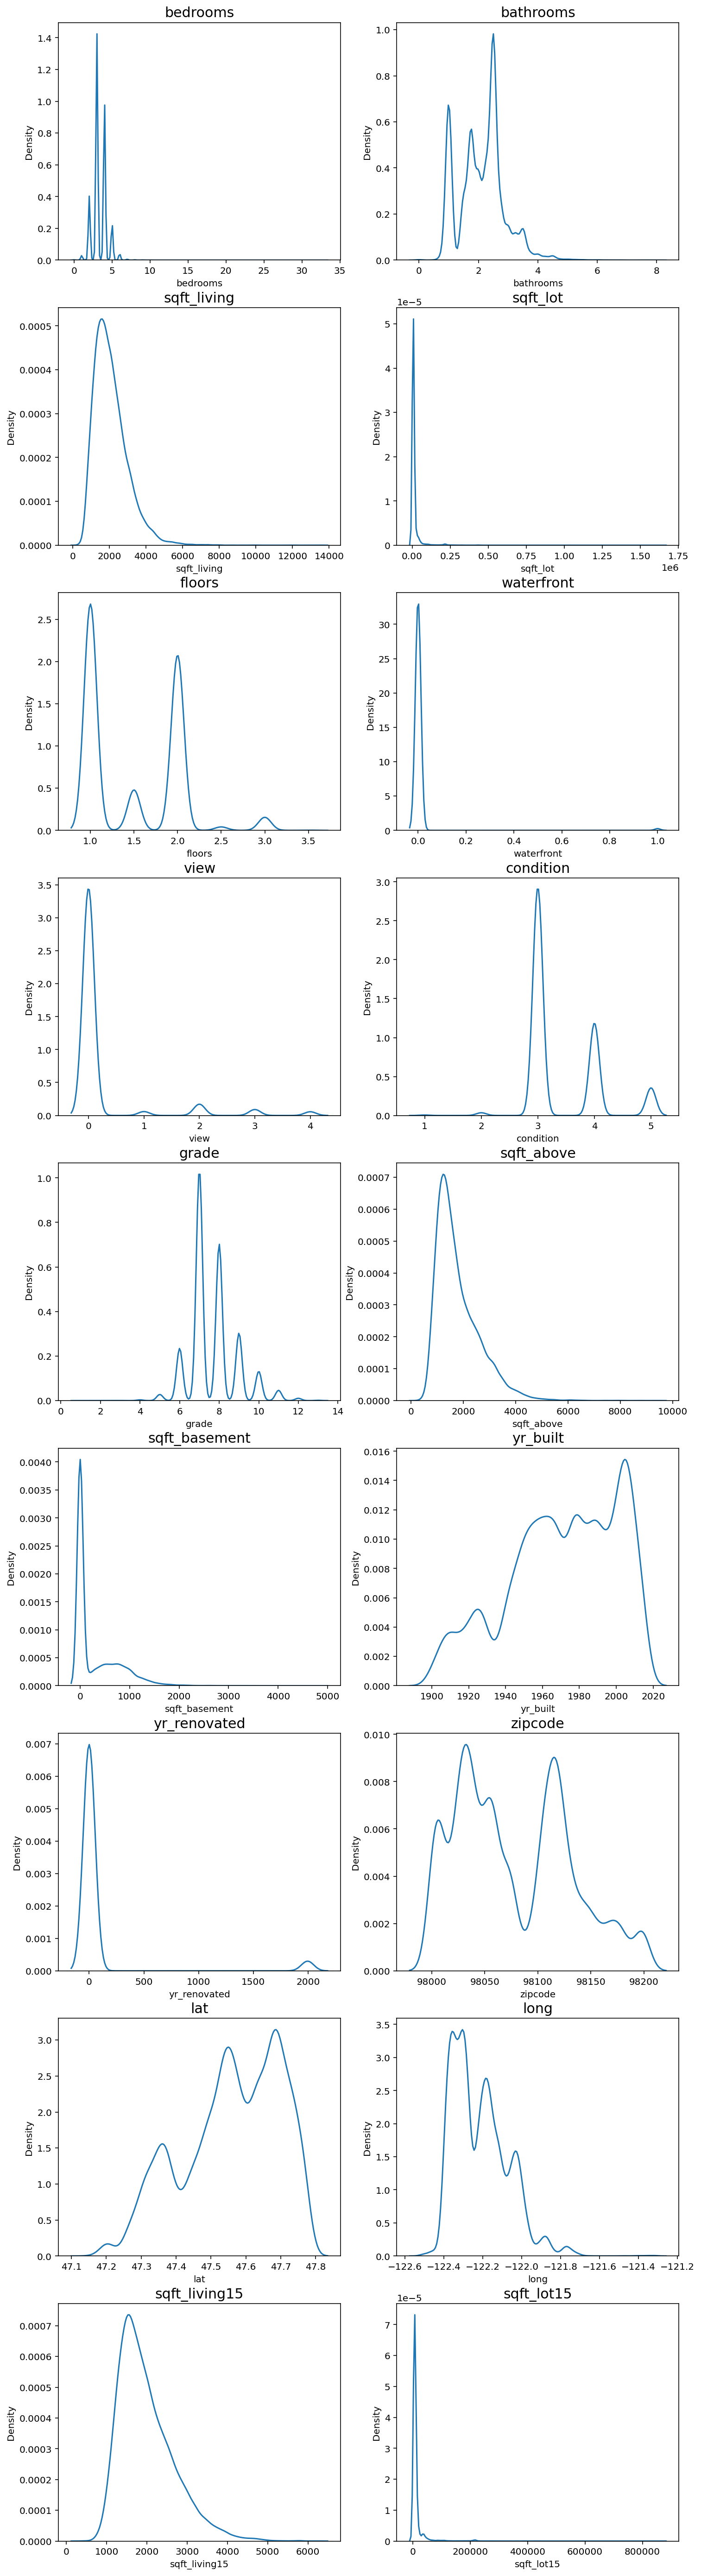

In [11]:
fig, ax = plt.subplots(9, 2, figsize=(12, 50))   


count = 1
columns = data.columns
for row in range(9):
    for col in range(2):
        sns.kdeplot(data=data[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 19 :
            break
# id 변수는 제외하고 분포를 확인함 / kdeplot은 이산(discrete)데이터의 경우에도 부드러운 곡선으로 전체분포를 시각화


### log-scaling을 통해 데이터 분포를 정규분포로 변경

In [12]:
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']

for c in skew_columns:
    data[c] = np.log1p(data[c].values)

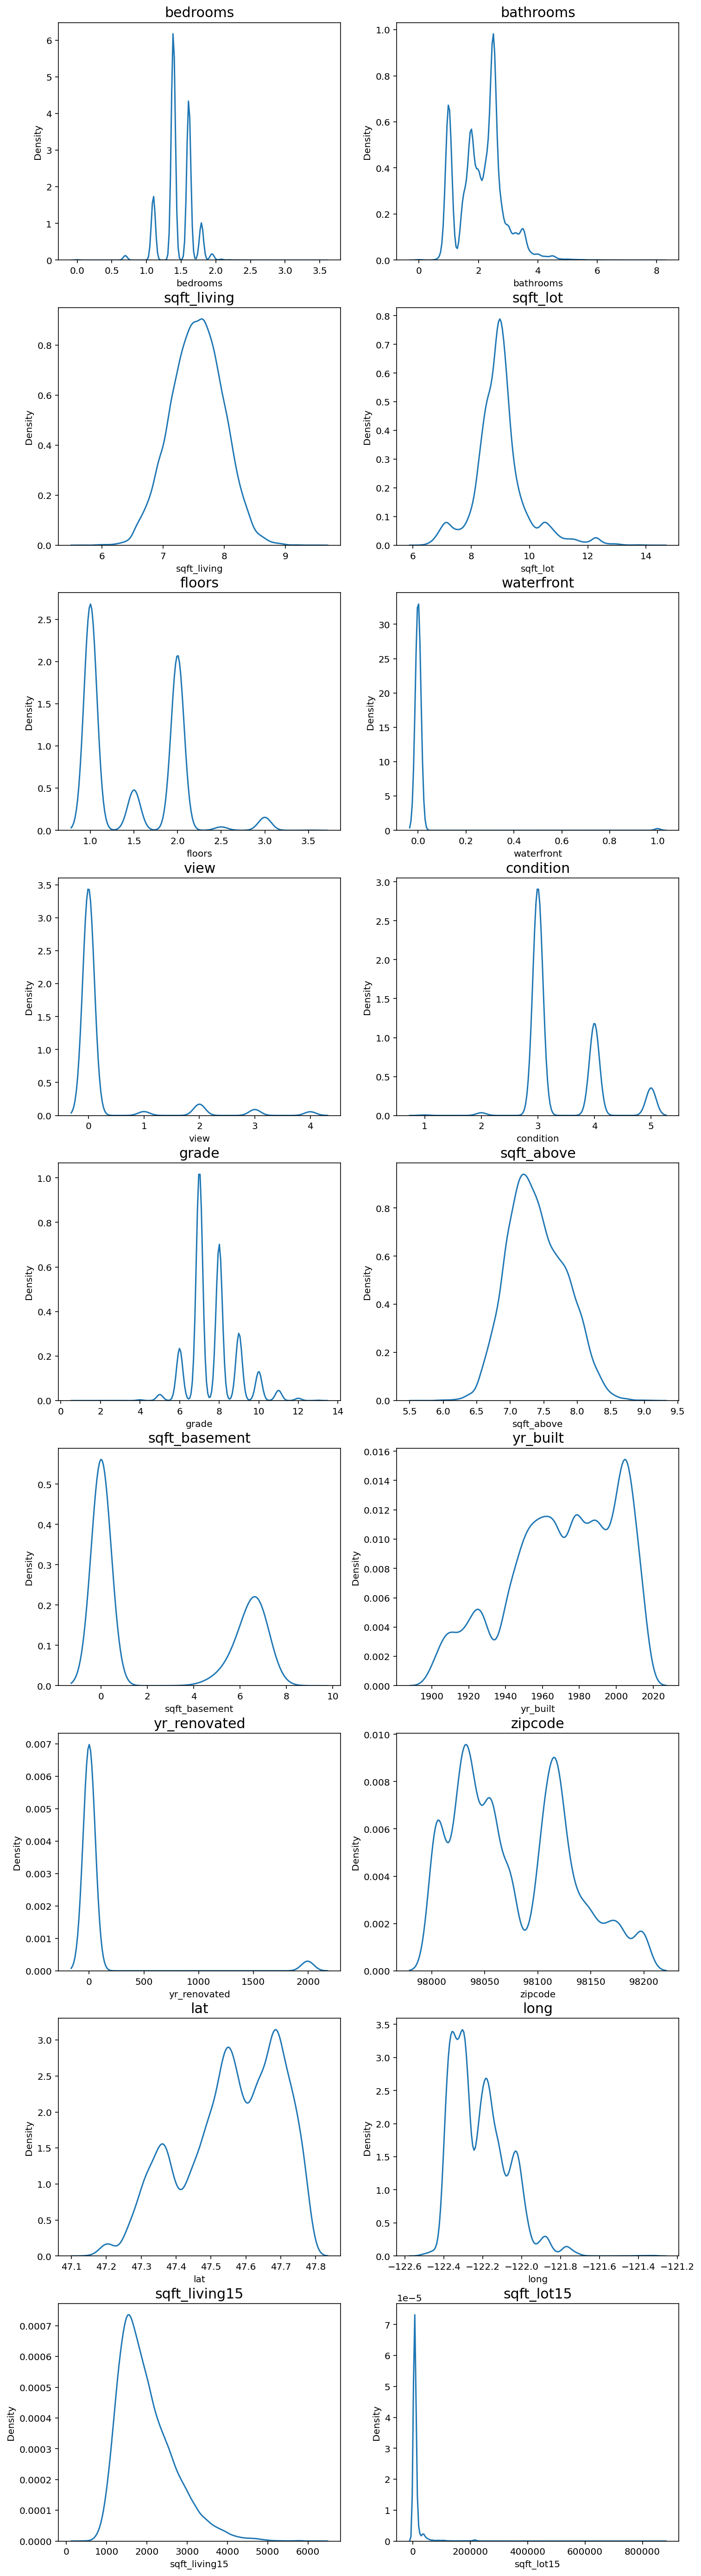

In [13]:
fig, ax = plt.subplots(9, 2, figsize=(12, 50))   # 가로스크롤 때문에 그래프 확인이 불편하다면 figsize의 x값을 조절해 보세요. 

# id 변수(count==0인 경우)는 제외하고 분포를 확인함.
count = 1
columns = data.columns
for row in range(9):
    for col in range(2):
        sns.kdeplot(data=data[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 19 :
            break
# id 변수는 제외하고 분포를 확인함 / kdeplot은 이산(discrete)데이터의 경우에도 부드러운 곡선으로 전체분포를 시각화


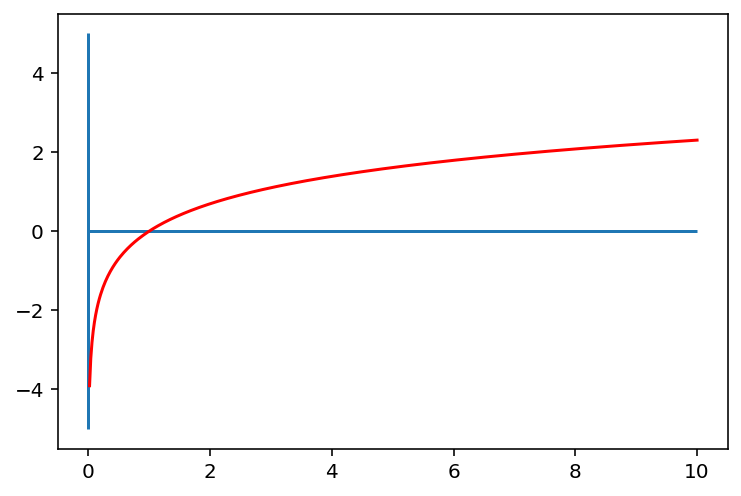

In [14]:
xx = np.linspace(0, 10, 500)
yy = np.log(xx)

plt.hlines(0, 0, 10)
plt.vlines(0, -5, 5)
plt.plot(xx, yy, c='r')
plt.show()

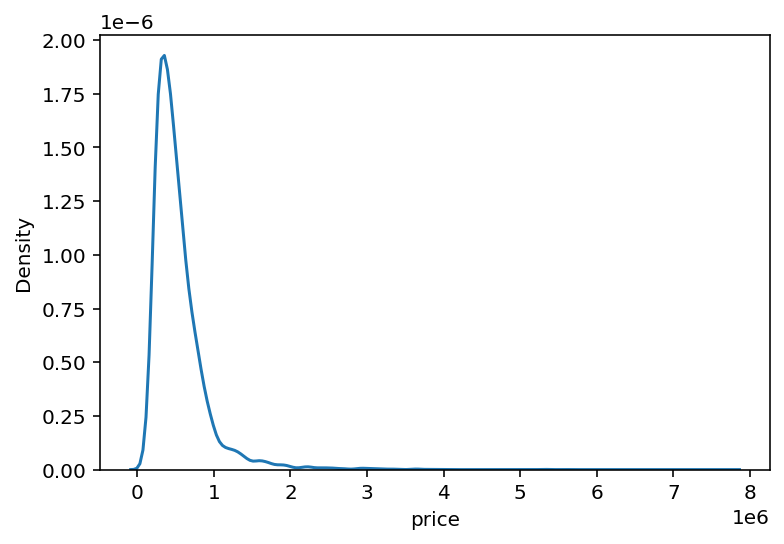

In [15]:
sns.kdeplot(y)
plt.show()

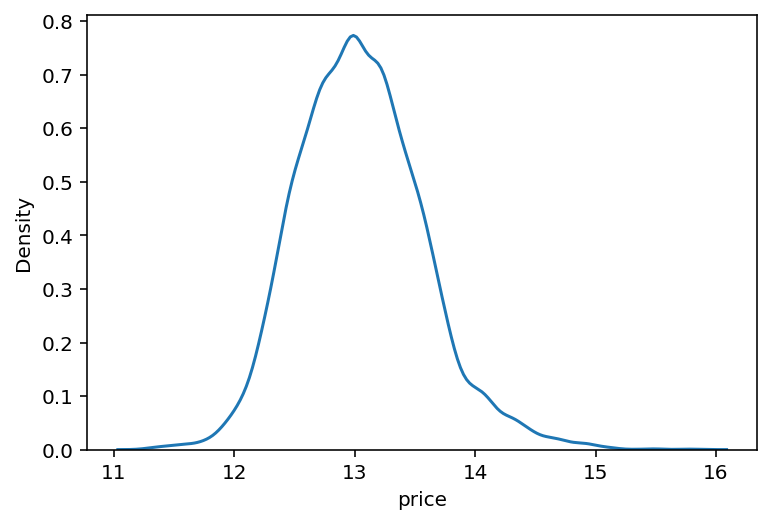

In [16]:
y_log_transformation = np.log1p(y)

sns.kdeplot(y_log_transformation)
plt.show()

In [17]:
# # 데이터 전체를 다시 나누어주기
# #위에서 저장해두었던 train_len을 인덱스로 활용해서 :train_len까지는 학습 데이터, 즉 x에 저장하고, 
# # train_len: 부터는 실제로 추론을 해야 하는 테스트 데이터, 즉 sub 변수에 저장함.
sub = data.iloc[train_len:, :]
x = data.iloc[:train_len, :]
# y = data.iloc[:train_len, :]

print(x.shape)
print(sub.shape)

(15035, 19)
(6468, 19)


In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21503 entries, 0 to 6467
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           21503 non-null  int64  
 1   bedrooms       21503 non-null  float64
 2   bathrooms      21503 non-null  float64
 3   sqft_living    21503 non-null  float64
 4   sqft_lot       21503 non-null  float64
 5   floors         21503 non-null  float64
 6   waterfront     21503 non-null  int64  
 7   view           21503 non-null  int64  
 8   condition      21503 non-null  int64  
 9   grade          21503 non-null  int64  
 10  sqft_above     21503 non-null  float64
 11  sqft_basement  21503 non-null  float64
 12  yr_built       21503 non-null  int64  
 13  yr_renovated   21503 non-null  int64  
 14  zipcode        21503 non-null  int64  
 15  lat            21503 non-null  float64
 16  long           21503 non-null  float64
 17  sqft_living15  21503 non-null  int64  
 18  sqft_lo

# 데이터 모델링

## Grid Search

In [19]:
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

In [20]:
gboost = GradientBoostingRegressor(random_state=2019)
xgboost = xgb.XGBRegressor(random_state=2019)
lightgbm = lgb.LGBMRegressor(random_state=2019)


models = [{'model':gboost, 'name':'GradientBoosting'}, {'model':xgboost, 'name':'XGBR'},
          {'model':lightgbm, 'name':'LightGBM'}]

In [21]:
gboost.__class__.__name__

'GradientBoostingRegressor'

In [27]:
def get_scores(models, train, y):
    df = {}
    
    for model in models:
        model_name = model.__class__.__name__
        
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        df[model_name] = rmse(y_test, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
            
    return score_df

## LGBMRegressor

In [31]:
random_state = 2020
param_grid = {
    'objective':['regression'],
    'learning_rate' : [0.05],
    'n_estimators':[50, 100],
    'max_depth': [1, 10],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, x, y, param_grid, verbose=1, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


,learning_rate,max_depth,n_estimators,objective,score,RMSLE
3,0.05,10,100,regression,-1.718487e+10,131091.071769
2,0.05,10,50,regression,-2.120923e+10,145633.877041
1,0.05,1,100,regression,-4.833706e+10,219856.915989
0,0.05,1,50,regression,-6.446066e+10,253891.031948


## XGBRegressor

In [32]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [10],
}

model = XGBRegressor(random_state=random_state)
my_GridSearch(model, x, y, param_grid, verbose=1, n_jobs=5)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


/opt/conda/lib/python3.9/site-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  warni

,max_depth,n_estimators,score,RMSLE
0,10,50,-1.791963e+10,133864.216128
1,10,100,-1.793283e+10,133913.498405


## GradientBoostingRegressor

In [33]:
param_grid = {
    'learning_rate': [0.05],
    'n_estimators':[50, 100],
    'max_depth': [1, 10],
}

model = GradientBoostingRegressor(random_state=random_state)
my_GridSearch(model, x, y, param_grid, verbose=1, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


,learning_rate,max_depth,n_estimators,score,RMSLE
3,0.05,10,100,-1.770742e+10,133069.215289
2,0.05,10,50,-1.960793e+10,140028.334947
1,0.05,1,100,-4.753226e+10,218018.937361
0,0.05,1,50,-6.443685e+10,253844.146878


# 데이터 훈련 및 예측

In [34]:
LGB_model = LGBMRegressor(max_depth=10, n_estimators=500, learning_rate=0.5, objective='regression', random_state=random_state)

In [35]:
LGB_model.fit(x, y)
LGB_prediction = LGB_model.predict(sub)
LGB_prediction = np.expm1(LGB_prediction)

In [36]:
XGB_model = XGBRegressor(max_depth=5, n_estimators=1000, learning_rate=0.05, subsample=0.9, random_state=random_state)
XGB_model.fit(x, y)
XGB_prediction = XGB_model.predict(sub)
XGB_prediction = np.expm1(XGB_prediction)

In [37]:
GBR_model = GradientBoostingRegressor(max_depth=5, n_estimators=1000, learning_rate=0.05, subsample=0.9, random_state=random_state)
GBR_model.fit(x, y)
GBR_prediction = GBR_model.predict(sub)
GBR_prediction = np.expm1(GBR_prediction)

In [40]:
def my_GridSearch(model, train, y, param_grid, cv=5, verbose=1, n_jobs=5):
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5, verbose=verbose, n_jobs=n_jobs)
    grid_model.fit(train, y)
    
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    results = pd.DataFrame(params)
    results['score'] = score
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')
    
    return results

위의 모델들을 비교했을 떄 LightGBM 모델에서 가장 점수가 좋게 나옴을 확인함.(learning rate =0.5, max_depth =10, n_estimators 100, objective regression, RMSLE : 131091.071769)

In [45]:
#좋은 모델 찾기
param_grid = {
    'boosting' : ['goss'],
    'n_estimators': [960],
    'max_depth': [5],
    'learning_rate': [0.04]
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, x, y, param_grid, verbose=1, n_jobs=5)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss


,boosting,learning_rate,max_depth,n_estimators,score,RMSLE
0,goss,0.04,5,960,-1.452014e+10,120499.55469


In [49]:
model = LGBMRegressor(max_depth=10, n_estimators=100, random_state=random_state)
model.fit(x, y)
prediction = model.predict(sub)
prediction

array([ 510073.43422111,  445045.52207699, 1291842.41370212, ...,
        457604.36199446,  332109.32763046,  424419.99889325])

In [50]:
prediction = np.expm1(prediction)
prediction

array([inf, inf, inf, ..., inf, inf, inf])

In [51]:
#딕셔너리 안에 있는 모델을 모두 x와 y로 학습시킨 뒤 predictions에 그 예측 결괏값을 모아서 평균한 값을 반환
def AveragingBlending(models, x, y, sub_x):
    for m in models : 
        m['model'].fit(x.values, y)
    
    predictions = np.column_stack([
        m['model'].predict(sub_x.values) for m in models
    ])
    return np.mean(predictions, axis=1)

In [52]:
y_pred = AveragingBlending(models, x, y, sub)
print(len(y_pred))
y_pred

6468


array([ 529966.66304912,  430726.21272617, 1361676.91242777, ...,
        452081.69137012,  341572.97685942,  421725.1231835 ])

In [67]:
def get_cv_score(models):
    kfold = KFold(n_splits=5).get_n_splits(x.values)
    for m in models:
        CV_score = np.mean(cross_val_score(m['model'], X=x.values, y=y, cv=kfold))
        print(f"Model: {m['name']}, CV score:{CV_score:.4f}")

In [68]:
get_cv_score(models)

Model: GradientBoosting, CV score:0.8597
Model: XGBR, CV score:0.8861
Model: LightGBM, CV score:0.8819


In [62]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


In [63]:
result = pd.DataFrame({
    'id' : sub_id, 
    'price' : y_pred
})

result.head()

,id,price
0,15035,5.299667e+05
1,15036,4.307262e+05
2,15037,1.361677e+06
3,15038,3.338036e+05
4,15039,3.089006e+05


In [64]:
my_submission_path = join(data_dir, 'submission.csv')
result.to_csv(my_submission_path, index=False)

print(my_submission_path)

/aiffel/aiffel/kaggle_kakr_housing/data/submission.csv


# Report

본 프로젝트는 GradientBoostingRegressor,XGBRegressor,LightGBMRegressor 세가지 모델을 비교하였고, CV점수는 그 중 XGBRegressor가 높았으나, RMSLE에서는 LightGBM 모델에서 가장 성능이 좋음을 발견했음 (n_estimators': [960],'max_depth': [5],'learning_rate': [0.04]로 설정했을 때 가장 우수한 점수를 보였음.)

아쉽게도, 캐글 private점수는 116127.87308/ public 점수는120031.23722로 측정되었음.

### 오류발생 및 대처
첫번째, XGBRegressor적용 중 Found input variables with inconsistent numbers of samples: [21503, 15035]에러 발생함.

- 해결방안
(1) 데이터 정리에서 float or int로만 정리되야된다는 걸 깨닫고 수정함.
(2) model적용 lms의 내용을 거의다 가져오다보니 train과 x값 설정을 어떻게 했는지 정확히 인지하지 못하여 수정함.
(3) n_estimator 및 max_depth 의 수치들을 변경함.(verbose 및 n_jobs의 수치를 변경함에도 변동이 없었음)

두번째, stacking ensemble을 적용하기 위하여 각 모듈을 저장하고 각 사이즈를 확인하였을 때 수치가 동일하였으나, y의 사이즈가 맞지않는다는 오류가 계속 발생하여 구글링하여 찾으려했으나 실패하였고, 파라미터를 하나하나씩 수정해가는 수고를 거쳤음.


## 기타 알게된 지식

### 1. 앙상블(Ensemble)
: 머신러닝에서 주로 쓰이는 알고리즘으로써, 앙상블은 크게 votting,bagging, boosting, stacking이라는 방법이 있음

* stacking ensemble : 캐글 점수를 높이고자 할때 주로 쓰임.

기존 머신러닝 알고리즘은,
- X_train, y_train을 사용하여 model training
- validation이 있다면 중간중간 평가를 하며
- x_test를 이용해 최종예측하여 prediction값을 가지게 되고,
- y_test 와 predict값을 이용해 최종 평가하게 됨

하지만, stacking ensemble은 개별 모델이 예측한 데이터를 다시 training set으로 사용해서 학습한다는 것에 큰 차이가 있음.
- 원본 데이터의 train, test가 존재
- 원본 training data를 3개의 머신러닝 모델(SVM, Rndom forest, LGBM, 등)이 학습
- 각 모델마다 X_test를 넣어서 예측 후 predict를 뽑아냄(3개의 predict된 값)
- 3개의 predict를 다시 학습 데이터(new training data)로 사용
- 최종 model을 하나 선정해 학습(fit)하고 predict하여 최종평가함(개별 모델들의 predict를 다 따로 저장하고 통합해야됨!=데이터를 쌓아주는(stacking) 합치는 ensemble이라는 뜻.)
- stacking ensemble은 과적합의 문제점이 있어 잘 사용하지않고 캐글에서만 주로 사용되며, 이때 훈련횟수에 주의해야됨

예시)
svm_pred = svm.predict(X_test)
rf_pred : rf.predict(X_test)
lr_pred : lr.predict(X_test)

new_data = np.array([svm_pred,rf_pred,lr_pred])
new_Data.shape
-> 결과값 (3, 114) : 행이 3개(모델이 3개)열이 114개로 되어 있음을 나타냄.

new_data = np.transpose(new_data)
new_data.shape
-> 결과값 (114,3)

-> *stacking할 때 데이터의 shape에 주의해야됨(row는 x_test와 일치 해야됨, 밑에 나와있듯이 (ex)열 114개와 일치해야됨)

### 2. LightGBM 
: 트리 기반의 학습 알고리즘인 gradient boosting방식의 프레임 워크
- GPU를 활용하며, 메모리를 적게 차지하고 속도가 빠르고 결과가 정확함.
- 다른 알고리즘은 학습 나무를 수평으로 확장하는 반면, LGBM은 수직으로 확장함.(leaf-wise tree growth) - 최대 delta loss가 증가하도록 잎의 개수를 정함.(다른 level-wise알고리즘보다 낮은 loss를 달성하는 경향이 있으며, 데이터의 크기가 작은 경우 leaf-wise는 과적합 되기 쉬우므로 max_depth를 줄여줘야함) 

#### 주요 하이퍼파라미터

(1) Object : regression, binary, multiclass

(2) metric : mae, rmse, mape, binary_logloss, auc, cross_entropy, kullbac_leibler

(3) learning_rate 

(4) num_interations : 기본값이 100인데 1000정도는 해주는게 좋다함. 너무 크게하면 과적합 발생함, 같은 뜻으로 사용되는 옵션으로서, num_iteration, n_iter, num_tree, num_trees, num_round, num_rounds, num_boos_round, n_estimators

(5) max_depth: -1로 설정하면 제한없이 분기함. feature가 많다면 크게 설정해야됨. 파라미터 설정시 우선적으로 설정해야됨.

(6) boosting :
- 부스팅방법:기본값은 gbdt이며 정확도가 중요할때는 딥러닝의 드랍아웃과 같은 dart를 사용함. 샘플링을 이용하는 goss도 있음.
ex) default  = gbdt, options: gdbt, rf, dart, goss

(7) bagging_fraction  배깅을 하기 위해서 데이터를 랜덤 샘플링하여 학습에 사용해야함. 비율은 0<fraction<=1이며 0이 되지않게 해야함. 

(8) feature_fraction : feature_fraction이 1보다 작다면 lgm은 매 iteration(tree)마다 다른 feature를 랜덤하게 추출하여 학습하게 됨. 만약, 0.8로 값을 설정하면 매 tree를 구성할 때, feature의 80%만 랜덤하게 선택함. 과적합을 방지하기 위해 사용할 수있으며 학습속도가 향상됨.

(9) scale_pos_weight : 클래스 불균형의 데이터 셋에서 weight를 주는 방식으로positive를 증가시킴. 기본값은 1이며 불균형의 정도에 따라 조절함.

(10) early_stopping_round : validation 셋에ㅐ서 평가지표가 더이상 향상되지 않으면 학습을 정지함. 평가지표의 향상이 n round이 상 지속되면 학습을 저이함

(11) lambda_l1, lambda_l2 : 정규화를 통해 과적합을 방지 할 수있지만, 정확도를 저하시킬 수도 있기 때문에 일반적으로 default값인 0으로 둠.

결론

(1) 더 빠른 속도
- bagging_fraction
- max_bin은 작게
- save_binary를 쓰면 데이터 로딩속도가 빨라짐
- parallel learning사용

(2) 더 높은 정확도
- max_bin을 크게
- num_iterations 는 크게하고 learning_rate는 작게
- num_leaves를 크게(과적합 원인될 수 있으므로 주의)
- boosting 알고리즘 'dart'사용

(3) 과적합을 줄이기
- max_bin을 작게
- num_leaves를 작게
- min_data_in_leaf와 min_sum_hessian_in_leaf사용하기



### 참고 : 
LGBM 모델 : https://greatjoy.tistory.com/72 

stacking_ensemble ; https://lsjsj92.tistory.com/558

과제참고 : https://github.com/JaeHeee/AIFFEL_Project/blob/master/EXPLORATION/EXPLORATION%208.%20%EB%82%98%EC%9D%98%20%EC%B2%AB%20%EB%B2%88%EC%A7%B8%20%EC%BA%90%EA%B8%80%20%EA%B2%BD%EC%A7%84%EB%8C%80%ED%9A%8C%2C%20%EB%AC%B4%EC%9E%91%EC%A0%95%20%EB%94%B0%EB%9D%BC%ED%95%B4%EB%B3%B4%EA%B8%B0.ipynb